In [1]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import array_to_img
from keras.preprocessing.image import save_img
from os import listdir
from numpy import zeros
from numpy import asarray
from numpy import load
from numpy import savez_compressed
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.optimizers import SGD # stocastic gradient descent
from sklearn.model_selection import train_test_split
#from sklearn.metrics import fbeta_score, accuracy_score
#from keras import backend
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import load_model

Using TensorFlow backend.


In [2]:
# READING IN THE CSV FILE
csv_file = pd.read_csv('Book1.csv')

In [3]:
csv_file.head()

,image_name,tags
0,train_0,car black sports elevated frontview outside
1,train_1,car white sports sideview outside
2,train_2,car white sports sideview inside
3,train_3,car white sports rareview inside
4,train_4,cars white black classic elevated_frontview ou...


In [4]:
# create mapping of tags and the inverse function
def tag_mapper(csv_file):
    labels = set() # using a set removes the duplicates.
    for i in range(len(csv_file)):
        tags = csv_file['tags'][i].split(" ") # split the tags at whitespaces
        labels.update(tags)
    labels = list(labels) # convert from set to list
    labels.sort() # sorts alphabetically
    # This dictionary maps labels to integers, and the reverse
    mapped_labels = {labels[i]:i for i in range(len(labels))}
    inv_mapped_labels = {i:labels[i] for i in range(len(labels))}
    return (mapped_labels, inv_mapped_labels)

In [5]:
# create a mapping of filename to list of tags
def image_name_mapper(csv_file):
    mapping = dict()
    for i in range(len(csv_file)):
        name, tags = csv_file["image_name"][i], csv_file['tags'][i]
        mapping[name] = tags.split(" ")
    return (mapping) # returns a dict

In [6]:
# create a one hot encoder
def one_hot_encoder(tags, mapped_tag):
    encoding = zeros(len(mapped_tag), dtype ='uint8')
    for tag in tags:
        encoding[mapped_tag[tag]] = 1
    return encoding

In [7]:
# load all images into memory
def load_dataset(img_folder, mapped_names, mapped_labels):
    photos, targets = list(), list()
    # enumerate files in the directory
    for filename in listdir(img_folder):
        # load image
        if filename != 'Thumbs.db':
            photo = load_img(img_folder + filename, target_size =(224,224))
            # convert to numpy array
            photo = img_to_array(photo, dtype='uint8')
            # get tags
            tags = mapped_names[filename[:-4]] # returns the values of a dict , to access the values you use [] instead of ()
            #one hot encoding tags
            target = one_hot_encoder(tags, mapped_labels)
            # store
            photos.append(photo)
            targets.append(target)
    X = asarray(photos, dtype = 'uint8')
    Y = asarray(targets, dtype = 'uint8')
    return X, Y

In [8]:
# creating a mapping of tags to integers
mapped_labels, inv_mapped_labels = tag_mapper(csv_file)

In [9]:
mapped_labels

{'': 0,
 'aqua': 1,
 'black': 2,
 'blue': 3,
 'car': 4,
 'cars': 5,
 'classic': 6,
 'elevated': 7,
 'elevated_frontview': 8,
 'elevated_rareview': 9,
 'elevated_topview': 10,
 'frontview': 11,
 'gold': 12,
 'gray': 13,
 'green': 14,
 'inside': 15,
 'jeep': 16,
 'matte_gray': 17,
 'outside': 18,
 'purple': 19,
 'rareview': 20,
 'red': 21,
 'sideview': 22,
 'sport': 23,
 'sports': 24,
 'truck': 25,
 'white': 26}

In [10]:
# creating a mapping of tag list to image name
mapped_names = image_name_mapper(csv_file)

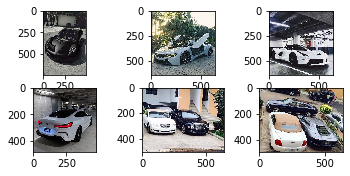

In [11]:
# loading in the image
img_folder = 'data/' # IMAGE FOLDER
for i in range(6):     # READING IN THE IMAGES
    plt.subplot(330+1+i)
    image_filename = img_folder+ 'train_'+str(i)+'.jpg'
    image = imread(image_filename)
    plt.imshow(image)
plt.show()   # first 6 images 

In [12]:
X, Y = load_dataset(img_folder, mapped_names, mapped_labels)

In [13]:
print(X.shape, Y.shape)

(21, 224, 224, 3) (21, 27)


In [14]:
# save both arrays  and targets to one file in compressed format
savez_compressed('compressed_data.npz', X, Y)

### ----------------------------------------------------------------------------------------------------------------------------

In [15]:
#run this code to check if loaded properly
# load the dataset from dummy_data
data = load('compressed_data.npz')    
X,y = data['arr_0'], data['arr_1']
print( X.shape, y.shape)

(21, 224, 224, 3) (21, 27)


In [16]:
def load_dataset(X, Y):
    # seperating the dataset into train and test datasets
    train_x, test_x,train_y,test_y = train_test_split(X, Y, test_size = 0.2, random_state =3)
    print(train_x.shape, test_x.shape,train_y.shape,test_y.shape)
    return(train_x, test_x, train_y, test_y)

### Creating the CNN model using the VGG type structure

In [17]:
def cnn_model(input_shape =(224,224,3), output_shape = 27):
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer ='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum =0.9)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy']) # I would be using accuracy as my metric
    return model

In [18]:
# plotting the learning curves, this function will show the loss and the accuracy

def summary(info):
    # plot loss
    plt.subplot(211)
    plt.title('Cross Entropy Loss')
    plt.plot (info.history['loss'], color='blue', label='train')
    plt.plot (info.history['val_loss'], color='orange', label='test')
    plt.legend(["Loss","Validation Loss"])
    
    # plot accuracy
    plt.subplot(212)
    plt.title('Classification Accuracy')
    plt.plot (info.history['accuracy'], color='blue', label='train')
    plt.plot (info.history['val_accuracy'], color='orange', label='test')
    plt.legend(["Accuracy","Validation Accuracy"])
    

In [19]:
def run_learning_sequence(X,Y):
    # load dataset
    # load dataset
    train_x, test_x,train_y,test_y = load_dataset(X, Y)
    
    #create data generator
    train_datagen = ImageDataGenerator(rescale =1.0/255.0,  horizontal_flip = True, vertical_flip = True, rotation_range = 90)
    test_datagen = ImageDataGenerator(rescale =1.0/255.0)
    
    # prepare iterations
    train = train_datagen.flow(train_x, train_y, batch_size = 2)
    test = test_datagen.flow(test_x, test_y, batch_size = 2)
    
    # define the model
    model = cnn_model()
    
    # fitting the model
    info = model.fit_generator(train, steps_per_epoch = len(train), validation_data = test, 
                                 validation_steps = len(test), epochs =15, verbose = 1)
    
    # evaluate the model
    loss, accuracy = model.evaluate_generator(test, steps = len(test), verbose = 0)
    print('> loss = %.3f, accuracy=%.3f' %(loss, accuracy))
    
    # display learning curves
    summary(info)

(16, 224, 224, 3) (5, 224, 224, 3) (16, 27) (5, 27)
Epoch 1/15
8/8 [==============================] - 10s 1s/step - loss: 0.6097 - accuracy: 0.6898 - val_loss: 0.5209 - val_accuracy: 0.8296
Epoch 2/15
8/8 [==============================] - 9s 1s/step - loss: 0.4700 - accuracy: 0.8056 - val_loss: 0.3584 - val_accuracy: 0.8815
Epoch 3/15
8/8 [==============================] - 9s 1s/step - loss: 0.4193 - accuracy: 0.8310 - val_loss: 0.4136 - val_accuracy: 0.8593
Epoch 4/15
8/8 [==============================] - 9s 1s/step - loss: 0.4153 - accuracy: 0.8380 - val_loss: 0.3428 - val_accuracy: 0.8519
Epoch 5/15
8/8 [==============================] - 9s 1s/step - loss: 0.4027 - accuracy: 0.8356 - val_loss: 0.4058 - val_accuracy: 0.8519
Epoch 6/15
8/8 [==============================] - 9s 1s/step - loss: 0.4018 - accuracy: 0.8264 - val_loss: 0.4162 - val_accuracy: 0.8444
Epoch 7/15
8/8 [==============================] - 9s 1s/step - loss: 0.4021 - accuracy: 0.8333 - val_loss: 0.4125 - val_accur

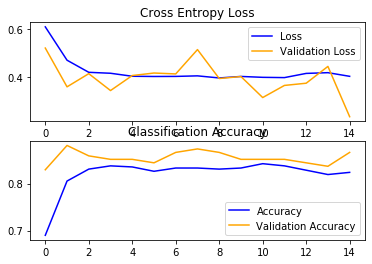

In [20]:
run_learning_sequence(X,Y)

In [21]:
# The model looks good, I'll try to see if I can increase the accuracy
# by using a pretrained model.

### USING TRASNFER LEARNING

In [22]:
def pre_cnn_model(input_shape =(224,224,3), output_shape = 27):
    # load model
    model = VGG16(include_top = False, input_shape = input_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    

    # add new classifying layers
    
    mod_flat = Flatten()(model.layers[-1].output)
    mod_class = Dense(128, activation="relu", kernel_initializer='he_uniform')(mod_flat)
    output = Dense(output_shape, activation = 'sigmoid')(mod_class)
    
    # define new model
    
    model = Model(inputs= model.inputs, outputs=output)
    
    # compile model
    opt = SGD(lr=0.01, momentum =0.9)
    model.compile(optimizer = opt, loss = 'binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:
def run_learning_sequence_2(X, Y):
    #load dataset
    # load dataset
    train_x, test_x,train_y,test_y = load_dataset(X, Y)
    
    #create data generator
    train_datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
    test_datagen = ImageDataGenerator(featurewise_center=True)
    
    # specify imagenet mean values for centering
    train_datagen.mean = [123.68, 116.779, 103.939]
    test_datagen.mean = [123.68, 116.779, 103.939]
    
    # prepare iterations
    train = train_datagen.flow(train_x, train_y, batch_size = 2)
    test = test_datagen.flow(test_x, test_y, batch_size = 2)
    
    # define model
    model = pre_cnn_model()
    # fitting the model
    
    info = model.fit_generator(train, steps_per_epoch = len(train), validation_data = test, 
                                 validation_steps = len(test), epochs =10, verbose = 1)
    
    # evaluate the model
    loss, accuracy = model.evaluate_generator(test, steps = len(test), verbose = 0)
    print('> loss = %.3f, accuracy = %.3f' %(loss, accuracy))
    
    # display learning curves
    summary(info)

(16, 224, 224, 3) (5, 224, 224, 3) (16, 27) (5, 27)
Epoch 1/10
8/8 [==============================] - 37s 5s/step - loss: 20.2998 - accuracy: 0.6782 - val_loss: 7.4266 - val_accuracy: 0.6519
Epoch 2/10
8/8 [==============================] - 35s 4s/step - loss: 8.2513 - accuracy: 0.6759 - val_loss: 0.6821 - val_accuracy: 0.6593
Epoch 3/10
8/8 [==============================] - 35s 4s/step - loss: 3.9644 - accuracy: 0.7315 - val_loss: 0.6903 - val_accuracy: 0.8000
Epoch 4/10
8/8 [==============================] - 35s 4s/step - loss: 2.9086 - accuracy: 0.7523 - val_loss: 0.6867 - val_accuracy: 0.8741
Epoch 5/10
8/8 [==============================] - 35s 4s/step - loss: 2.6214 - accuracy: 0.8148 - val_loss: 0.6830 - val_accuracy: 0.8741
Epoch 6/10
8/8 [==============================] - 35s 4s/step - loss: 3.3232 - accuracy: 0.8171 - val_loss: 0.6784 - val_accuracy: 0.8741
Epoch 7/10
8/8 [==============================] - 35s 4s/step - loss: 0.7867 - accuracy: 0.8310 - val_loss: 0.6757 - va

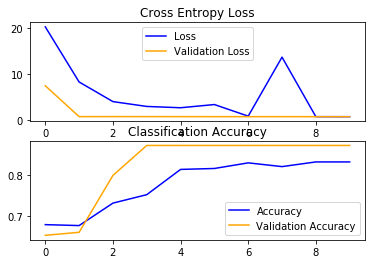

In [24]:
run_learning_sequence_2(X, Y)

### Create two final models, the cnn_model and the pre_cnn_model

### cnn_model

In [25]:
def cnn_model(input_shape =(224,224,3), output_shape = 27):
    model = Sequential()
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same', input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(Conv2D(32,(3,3), activation ='relu', kernel_initializer ='he_uniform', padding='same'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer ='he_uniform'))
    model.add(Dense(output_shape, activation='sigmoid'))
    # compile model
    opt = SGD(lr=0.01, momentum =0.9)
    model.compile(optimizer = opt, loss = 'binary_crossentropy') 
    return model

In [26]:
def run_learning_sequence(X,Y):  
    #create data generator
    datagen = ImageDataGenerator(rescale =1.0/255.0,  horizontal_flip = True, vertical_flip = True, rotation_range = 90)
     
    # prepare iterations
    train = datagen.flow(X, Y, batch_size = 2)
    
    # define the model
    model = cnn_model()
    
    # fitting the model
    info = model.fit_generator(train, steps_per_epoch = len(train), epochs =15, verbose = 1)
    
    # saving the model
    model.save('final_cnn_model.h5')
                                  

In [27]:
run_learning_sequence(X,Y)

Epoch 1/15
11/11 [==============================] - 12s 1s/step - loss: 0.6752
Epoch 2/15
11/11 [==============================] - 12s 1s/step - loss: 0.4434
Epoch 3/15
11/11 [==============================] - 11s 975ms/step - loss: 0.4048
Epoch 4/15
11/11 [==============================] - 11s 970ms/step - loss: 0.3839
Epoch 5/15
11/11 [==============================] - 11s 979ms/step - loss: 0.3810
Epoch 6/15
11/11 [==============================] - 11s 971ms/step - loss: 0.3852
Epoch 7/15
11/11 [==============================] - 11s 973ms/step - loss: 0.3901
Epoch 8/15
11/11 [==============================] - 11s 998ms/step - loss: 0.3829
Epoch 9/15
11/11 [==============================] - 11s 974ms/step - loss: 0.3794
Epoch 10/15
11/11 [==============================] - 11s 985ms/step - loss: 0.3819
Epoch 11/15
11/11 [==============================] - 11s 971ms/step - loss: 0.3867
Epoch 12/15
11/11 [==============================] - 11s 976ms/step - loss: 0.3763
Epoch 13/15
11/11 [

### pre_cnn_model

In [28]:
def pre_cnn_model(input_shape =(224,224,3), output_shape = 27):
    # load model
    model = VGG16(include_top = False, input_shape = input_shape)
    # mark loaded layers as not trainable
    for layer in model.layers:
        layer.trainable = False
    
    # add new classifying layers
    
    mod_flat = Flatten()(model.layers[-1].output)
    mod_class = Dense(128, activation="relu", kernel_initializer='he_uniform')(mod_flat)
    output = Dense(output_shape, activation = 'sigmoid')(mod_class)
    
    # define new model
    
    model = Model(inputs= model.inputs, outputs=output)
    
    # compile model
    opt = SGD(lr=0.01, momentum =0.9)
    model.compile(optimizer = opt, loss = 'binary_crossentropy')
    return model

In [29]:
def run_learning_sequence_2(X, Y):
    
    #create data generator
    datagen = ImageDataGenerator(featurewise_center=True, horizontal_flip=True, vertical_flip=True, rotation_range=90)
        
    # specify imagenet mean values for centering
    datagen.mean = [123.68, 116.779, 103.939]
    
    # prepare iterations
    train = datagen.flow(X, Y, batch_size = 2)
   
    
    # define model
    model = pre_cnn_model()
    # fitting the model
    
    info = model.fit_generator(train, steps_per_epoch = len(train), epochs =10, verbose = 1)
    
    # saving the model
    model.save('final_pre_cnn_model.h5')

In [30]:
run_learning_sequence_2(X, Y)

Epoch 1/10
11/11 [==============================] - 38s 3s/step - loss: 17.4303
Epoch 2/10
11/11 [==============================] - 36s 3s/step - loss: 17.0358
Epoch 3/10
11/11 [==============================] - 36s 3s/step - loss: 3.7589
Epoch 4/10
11/11 [==============================] - 36s 3s/step - loss: 1.7792
Epoch 5/10
11/11 [==============================] - 36s 3s/step - loss: 26.6010
Epoch 6/10
11/11 [==============================] - 36s 3s/step - loss: 4.0697
Epoch 7/10
11/11 [==============================] - 36s 3s/step - loss: 0.6610
Epoch 8/10
11/11 [==============================] - 36s 3s/step - loss: 0.8472
Epoch 9/10
11/11 [==============================] - 36s 3s/step - loss: 1.8639
Epoch 10/10
11/11 [==============================] - 36s 3s/step - loss: 0.6577


In [31]:
# Note if you are using both data augmentation and drop out regularization
# increase the number of epochs

### PREDICTIONS

In [32]:
def prediction_to_tags(inv_mapping, prediction):
    values  = prediction.round()
    # convert to predicted tags
    labels = [inv_mapping[i] for i in range(len(values)) if values[i] == 1.0]
    return labels

In [33]:
def load_new_image(filename):
    # load image
    image = load_img(filename, target_size=(224, 224))
    
    # convert to array
    image = img_to_array(image)
    
    #reshape into single sample with 3 channels
    image = image.reshape(1, 224, 224, 3)
    
    # center pixel data
    img = image.astype('float32')
    image = image - [123.68, 116.779, 103.939]
    return image

### cnn_model prediction

In [34]:
def run_example_1(image_string, inv_mapping):
    # load image
    img = load_new_image(image_string)
    
    # load model
    model = load_model('final_cnn_model.h5')
    
    # predict the class
    result = model.predict(img)
    #print(result[0])
    
    # map predictions to tags
    tags = prediction_to_tags(inv_mapping, result[0])
    print(tags)

### what the test images look like.

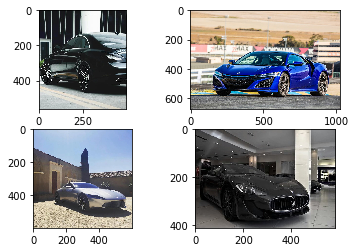

In [35]:
img_folder = 'test_data/' # IMAGE FOLDER
for i in range(4):     # READING IN THE IMAGES
    plt.subplot(220+1+i)
    image_filename = img_folder+ 'test_'+str(i)+'.jpg'
    image = imread(image_filename)
    plt.imshow(image)
plt.show() 

In [36]:
image_string_1 = 'test_data/test_0.jpg'
image_string_2 = 'test_data/test_1.jpg'
image_string_3 = 'test_data/test_2.jpg'
image_string_4 = 'test_data/test_3.jpg'

In [37]:
run_example_1(image_string_1, inv_mapped_labels)
run_example_1(image_string_2, inv_mapped_labels)
run_example_1(image_string_3, inv_mapped_labels)
run_example_1(image_string_4, inv_mapped_labels)

['', 'car', 'outside', 'red', 'sideview', 'sports']
['car', 'outside', 'red', 'sideview', 'sports']
['car', 'outside', 'sideview', 'sports']
['', 'car', 'outside', 'red', 'sideview', 'sports']


In [38]:
def run_example_2(image_string, inv_mapping):
    # load image
    img = load_new_image(image_string)
    
    # load model
    model = load_model('final_pre_cnn_model.h5')
    
    # predict the class
    result = model.predict(img)
    #print(result[0])
    
    # map predictions to tags
    tags = prediction_to_tags(inv_mapping, result[0])
    print(tags)

In [39]:
run_example_2(image_string_1, inv_mapped_labels)
run_example_2(image_string_2, inv_mapped_labels)
run_example_2(image_string_3, inv_mapped_labels)
run_example_2(image_string_4, inv_mapped_labels)

['car', 'outside', 'sports']
['car', 'outside', 'sports']
['car', 'outside', 'sports']
['car', 'outside', 'sports']


### Data meaning

In [41]:
# car : if one car is in the picture; cars for more than one
# sports : if the car is a maserati, lambo, ferarri and so on
# classic: if the car is a bently, roll royce and so on
# view : sideview, frontview, rareview of the car in the picture
# color : color of car,e.g gold, white, blue etc
# indoor : if the car is in roofed area
# outdoor : if the car is out in the open

In [42]:
# one of the limitations are not enough data, i created the data myself.

In [43]:
# Referrence : https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-satellite-photos-of-the-amazon-rainforest/